# MAP-Elites track generations

In [8]:
import numpy as np
import requests
from requests.exceptions import Timeout
from retrying import retry 
import random
from ribs.archives import GridArchive
from ribs.emitters import EmitterBase
from ribs.schedulers import Scheduler
from ribs.visualize import grid_archive_heatmap
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster
import logging
import json


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [9]:
BASE_URL = 'http://localhost:4242'
POINTS_COUNT = 50
MAX_SELECTED_CELLS = 10
SOLUTION_DIM = POINTS_COUNT * 2 + MAX_SELECTED_CELLS * 2 + 1 
TRACK_SIZE_RANGE = (2, 5)
LENGTH_RANGE = (400, 2000)
ITERATIONS = 500
ARCHIVE_DIM = 3
INIT_POPULATION = ARCHIVE_DIM * ARCHIVE_DIM 

DEBUG_CROSSOVER = True
DEBUG_MUTATION = True

In [10]:
cluster = LocalCluster(processes=True, n_workers=12, threads_per_worker=1)
client = Client(cluster)

C:\Users\batman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51266 instead
  warnings.warn(


### Helper functions

In [11]:
def generate_solution(iteration):
    response = requests.post(f'{BASE_URL}/generate', json={
        "id": iteration + random.random(),
        "mode": "voronoi",
        "trackSize": random.randint(TRACK_SIZE_RANGE[0], TRACK_SIZE_RANGE[1])
    })
    response.raise_for_status()
    return response.json()
    
def solution_to_array(solution):
    array = np.zeros(SOLUTION_DIM)
    # Fill in dataSet
    for i, point in enumerate(solution["dataSet"]):
        array[i*2] = point["x"]
        array[i*2 + 1] = point["y"]
    # Fill in selectedCells
    for i, cell in enumerate(solution["selectedCells"]):
        if i < MAX_SELECTED_CELLS:
            array[POINTS_COUNT*2 + i*2] = cell["x"]
            array[POINTS_COUNT*2 + i*2 + 1] = cell["y"]
    array[-1] = solution["id"]
    return array

def array_to_solution(array):
    dataSet = [{"x": float(array[i]), "y": float(array[i+1])} for i in range(0, POINTS_COUNT*2, 2)]
    selectedCells = [{"x": float(array[i]), "y": float(array[i+1])} 
                     for i in range(POINTS_COUNT*2, SOLUTION_DIM-1, 2) 
                     if array[i] != 0 or array[i+1] != 0]
    
    return {
        "id": float(array[-1]),
        "mode": "voronoi",
        "dataSet": dataSet,
        "selectedCells": selectedCells
    }

def get_fractional_part(id_value):
    return id_value - int(id_value)


@retry(stop_max_attempt_number=3, wait_fixed=2000)
def evaluate_solution(solution):
    try:
        response = requests.post(f'{BASE_URL}/evaluate', json=solution, timeout=30)  # 30 second timeout
        response.raise_for_status()
        result = response.json()
        fitness = result['fitness']
        objective = -(fitness['deltaX'] + fitness['deltaY'])
        measures = [len(solution['selectedCells']), fitness['length']]
        return objective, measures
    except Timeout:
        logging.warning(f"Timeout occurred while evaluating solution")
        return float('-inf'), [TRACK_SIZE_RANGE[0], LENGTH_RANGE[0]]
    except requests.RequestException as e:
        logging.warning(f"Error in evaluate_solution: {e}")
        return float('-inf'), [TRACK_SIZE_RANGE[0], LENGTH_RANGE[0]]
    

def format_number(n):
    if abs(n) > 1e5 or abs(n) < 1e-5:
        return f"{n:.2e}"
    else:
        return f"{n:.2f}"
    


def save_json(data, filename):
    with open(filename, 'w') as file:
        json.dump(data, file)

## Genetic operators

In [12]:
class CustomEmitter(EmitterBase):
    def __init__(self, archive, solution_dim, batch_size=ARCHIVE_DIM, bounds=None):
        super().__init__(archive, solution_dim=solution_dim, bounds=bounds)
        self.batch_size = batch_size
        self.iteration = 0

    def ask(self):
        self.iteration += 1
        if self.iteration <= INIT_POPULATION: 
            return np.array([solution_to_array(generate_solution(self.iteration-1)) for _ in range(self.batch_size)])
        elif np.random.random() < 0.5:  # Mutation
            return self.mutate_solutions()
        else:  # Crossover
            return self.crossover_solutions()

    def generate_initial_solutions(self):
        return np.array([solution_to_array(generate_solution(self.iteration-1)) for _ in range(self.batch_size)])


    def mutate_solutions(self):
        parents_data = self.archive.sample_elites(self.batch_size)
        mutated = []
        global total_mutations

        for i in range(self.batch_size):
            solution = parents_data['solution'][i]
            parent_dict = array_to_solution(solution)

            response = requests.post(f'{BASE_URL}/mutate', json={
                "individual": parent_dict,
                "intensityMutation": 10
            })
            response.raise_for_status()
            mutated_dict = response.json()['mutated']
            
            # Keep the same ID for mutations, just update the iteration part
            parent_frac = get_fractional_part(parent_dict['id'])
            mutated_dict['id'] = self.iteration - 1 + parent_frac
            
            mutated.append(solution_to_array(mutated_dict))
            if DEBUG_MUTATION:
                logger.info(f"Mutation {i+1}, Parent ID {parent_dict['id']}, Mutated ID {mutated_dict['id']}")
        total_mutations+=1
        return np.array(mutated)

    def crossover_solutions(self):
        offspring = []
        global total_crossovers
        for i in range(self.batch_size // 2):
            while True:
                parents = self.archive.sample_elites(2)
                parent1 = array_to_solution(parents['solution'][0])
                parent2 = array_to_solution(parents['solution'][1])
                
                if parent1['id'] != parent2['id']:
                    break

            response = requests.post(f'{BASE_URL}/crossover', json={
                "mode": "voronoi",
                "parent1": parent1,
                "parent2": parent2
            })
            response.raise_for_status()
            children = response.json()['offspring']
            # Create a new ID based on parents' IDs
            parent1_frac = get_fractional_part(parent1['id'])
            parent2_frac = get_fractional_part(parent2['id'])
            child_frac = (parent1_frac + parent2_frac) % 1  # Ensure it's between 0 and 1
            new_id = self.iteration - 1 + child_frac
            
            child = {
                "id": new_id,
                "mode": "voronoi",
                "trackSize": len(children['sel']),
                "dataSet": children['ds'],
                "selectedCells": children['sel']
            }
            
            if np.random.random() < 0.23:
                save_json(parent1, f"parent1_{self.iteration}_{i}.json")
                save_json(parent2, f"parent2_{self.iteration}_{i}.json")
                save_json(child, f"offspring_{self.iteration}_{i}.json")
            
            total_crossovers+=1
            offspring.append(solution_to_array(child))
            if DEBUG_CROSSOVER:
                logger.info(f"Crossover {i+1}, Child: Parent1 ID {parent1['id']}, Parent2 ID {parent2['id']}, Child ID {new_id}")
        
        return np.array(offspring)

## Illuminating search spaces by mapping elites


In [13]:
archive = GridArchive(solution_dim=SOLUTION_DIM,
                          dims=[ARCHIVE_DIM, ARCHIVE_DIM],
                          ranges=[TRACK_SIZE_RANGE, LENGTH_RANGE])

emitter = CustomEmitter(archive,
                            solution_dim=SOLUTION_DIM,
                            batch_size=INIT_POPULATION,
                            bounds=[(0, 600)] * (SOLUTION_DIM - 1) + [(0, float('inf'))])

scheduler = Scheduler(archive, [emitter])

total_evaluations = 0
total_crossovers = 0
total_mutations = 0


def run_map_elites(iterations):
    global total_evaluations, total_crossovers, total_mutations
    
    for itr in range(iterations):
        try:
            logging.info(f"Starting iteration {itr + 1}")
            
            logging.info("Calling scheduler.ask()")
            solution_batch = scheduler.ask()
            total_evaluations += len(solution_batch)
            
            logging.info("Evaluating solutions")
            futures = client.map(evaluate_solution, [array_to_solution(sol) for sol in solution_batch])
            
            logging.info("Gathering results")
            results = client.gather(futures)

            objectives = []
            measures_list = []

            for result in results:
                objective, measures = result
                if np.isfinite(objective):
                    objectives.append(objective)
                    measures_list.append(measures)
                else:
                    logging.warning(f"Non-finite objective value: {objective}. Using placeholder.")
                    objectives.append(-np.finfo(float).max)
                    measures_list.append(measures)

            if objectives and measures_list:
                scheduler.tell(objectives, measures_list)
                
                # Calculate archive statistics
                archive_data = archive.data()
                archive_objectives = archive_data['objective']
                archive_mean = np.mean(archive_objectives) if len(archive_objectives) > 0 else float('nan')
                archive_best = np.max(archive_objectives) if len(archive_objectives) > 0 else float('-inf')
                
                logging.info(f"Iteration {itr + 1}: "
                            f"Batch Mean = {format_number(np.mean(objectives))}, "
                            f"Batch Best = {format_number(np.max(objectives))}, "
                            f"Archive Size = {len(archive)}, "
                            f"Archive Coverage = {archive.stats.coverage:.2f}, "
                            f"Archive Mean = {format_number(archive_mean)}, "
                            f"Archive Best = {format_number(archive_best)}")
            else:
                logging.warning(f"Iteration {itr + 1}: No valid solutions to add to archive")

            if (itr + 1) % 10 == 0:
                plt.figure(figsize=(10, 8))
                grid_archive_heatmap(archive)
                plt.title(f"MAP-Elites Archive Heatmap - Iteration {itr + 1}")
                plt.xlabel("Track Size")
                plt.ylabel("Track Length")
                plt.savefig(f"archive_heatmap_iter_{itr + 1}.png")
                plt.close()

        except Exception as e:
            logging.error(f"Error in iteration {itr}: {str(e)}")
            raise

In [14]:
run_map_elites(ITERATIONS)

INFO:root:Starting iteration 1
INFO:root:Calling scheduler.ask()
INFO:root:Evaluating solutions
INFO:root:Gathering results
INFO:root:Iteration 1: Batch Mean = -2.00e+307, Batch Best = 0.65, Archive Size = 3, Archive Coverage = 0.33, Archive Mean = -1.02, Archive Best = 0.65
INFO:root:Starting iteration 2
INFO:root:Calling scheduler.ask()
INFO:root:Evaluating solutions
INFO:root:Gathering results
INFO:root:Iteration 2: Batch Mean = -1.81, Batch Best = 0.14, Archive Size = 4, Archive Coverage = 0.44, Archive Mean = -1.09, Archive Best = 0.65
INFO:root:Starting iteration 3
INFO:root:Calling scheduler.ask()
INFO:root:Evaluating solutions
INFO:root:Gathering results
INFO:root:Iteration 3: Batch Mean = -2.05, Batch Best = -0.58, Archive Size = 4, Archive Coverage = 0.44, Archive Mean = -0.27, Archive Best = 0.65
INFO:root:Starting iteration 4
INFO:root:Calling scheduler.ask()
INFO:root:Evaluating solutions
INFO:root:Gathering results
INFO:root:Iteration 4: Batch Mean = -2.55, Batch Best = -

## Visualize Results

INFO:root:Final Statistics: Evaluations = 3285, Crossovers = 972, Mutations = 248, Archive size = 8, Coverage = 0.89


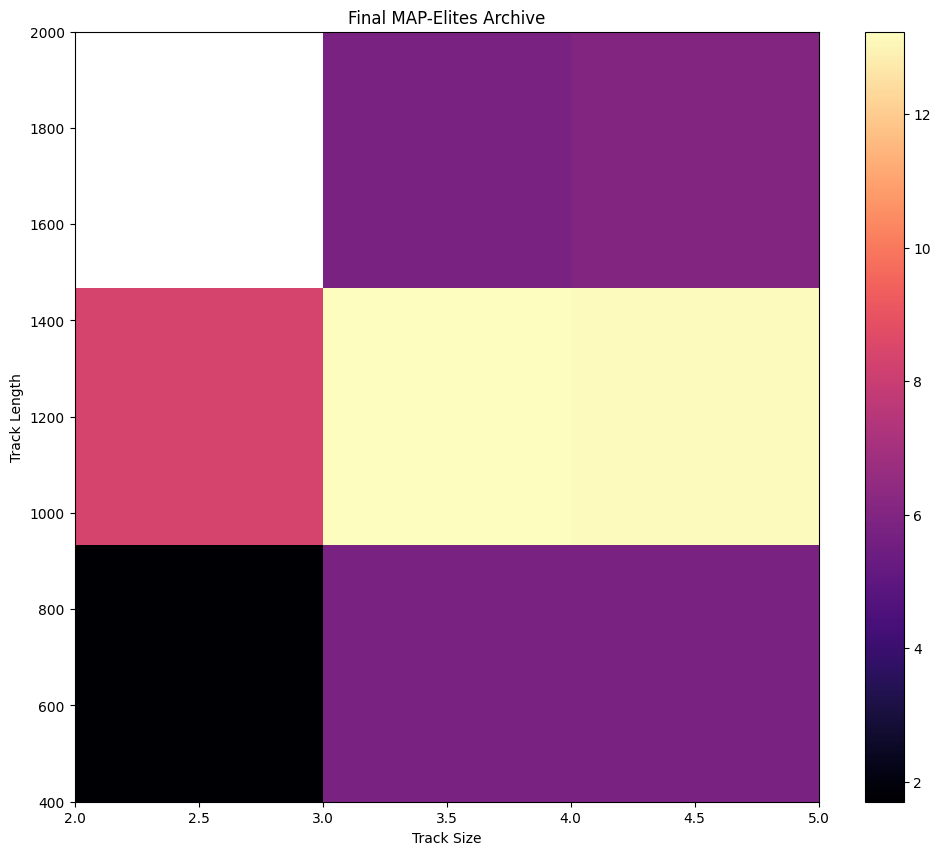

In [15]:
logging.info(f"Final Statistics: "
                f"Evaluations = {total_evaluations}, "
                f"Crossovers = {total_crossovers}, "
                f"Mutations = {total_mutations}, "
                f"Archive size = {len(archive)}, "
                f"Coverage = {archive.stats.coverage:.2f}")

plt.figure(figsize=(12, 10))
grid_archive_heatmap(archive)
plt.title("Final MAP-Elites Archive")
plt.xlabel("Track Size")
plt.ylabel("Track Length")
plt.savefig("final_archive_heatmap.png")
plt.show()